# Install Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.8 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-36k9lfst
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-36k9lfst
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=bc62e59a39758a912e4b83320723e0b5b0863927628b74a2788b2f32178a6be3
  Stored in directory: /tmp/pip-ephem-wheel-cache-9r14gx_d/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
%cd /content/drive/MyDrive/Coding/Project/TinyCLIP

/content/drive/MyDrive/Coding/Project/TinyCLIP


# New_clip_loss

In [ ]:
import torch
import clip
import torch.nn.functional as F
import numpy as np
from PIL import Image

def new_clip_loss(ori_image, ori_text, tar_image, tar_text):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/32", device=device)
    upsample = torch.nn.Upsample(scale_factor=7)
    avg_pool = torch.nn.AvgPool2d(kernel_size=1024 // 32) # kernel_size=opts.stylegan_size // 32
    cos_loss2 = torch.nn.CosineEmbeddingLoss()

    ori_image = avg_pool(upsample(ori_image))
    tar_image = avg_pool(upsample(tar_image))

    emb_ori = model.encode_image(F.interpolate(ori_image, size=224))  # B 512
    emb_tar = model.encode_image(F.interpolate(tar_image, size=224))

    emb_ori_text = model.encode_text(clip.tokenize(ori_text[0]).cuda())  # B 512
    emb_tar_text = model.encode_text(clip.tokenize(tar_text[0]).cuda())
    change_text = torch.from_numpy(np.array(ori_text[1] == ori_text[0])).view(-1, 1).repeat(1, emb_ori_text.shape[1]).cuda()
    emb_ori_text2 = model.encode_text(clip.tokenize(ori_text[1]).cuda())  # B 512
    emb_ori_text2 = torch.where(change_text == False, torch.zeros_like(emb_ori_text), emb_ori_text2)
    change_text = torch.from_numpy(np.array(tar_text[1]) == np.array(tar_text[0])).view(-1, 1).repeat(1, emb_tar_text.shape[1]).cuda()
    emb_tar_text2 = model.encode_text(clip.tokenize(tar_text[1]).cuda())
    emb_tar_text2 = torch.where(change_text == False, torch.zeros_like(emb_tar_text), emb_tar_text2)
    t_res = emb_ori - emb_ori_text - emb_ori_text2
    t_full = emb_tar_text + emb_tar_text2 + t_res

    cos_target = torch.ones((emb_tar.shape[0])).float().cuda()
    similarity = cos_loss2(emb_tar, t_full, cos_target)

    return similarity

# Loss

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device="cuda")

100%|███████████████████████████████████████| 338M/338M [00:13<00:00, 26.0MiB/s]


In [ ]:
image_1 = preprocess(Image.open("/content/drive/MyDrive/Coding/Project/TinyCLIP/img/camisole_long_jumpsuits.png")).unsqueeze(0).to(device)
text_1 = [["tank dress","short dress"],["tank short dress"]]

image_2 = preprocess(Image.open("/content/drive/MyDrive/Coding/Project/TinyCLIP/img/long_sleeve_shirt_and_pants.png")).unsqueeze(0).to(device)
text_2 = ["",["short shirt","shorts"]]

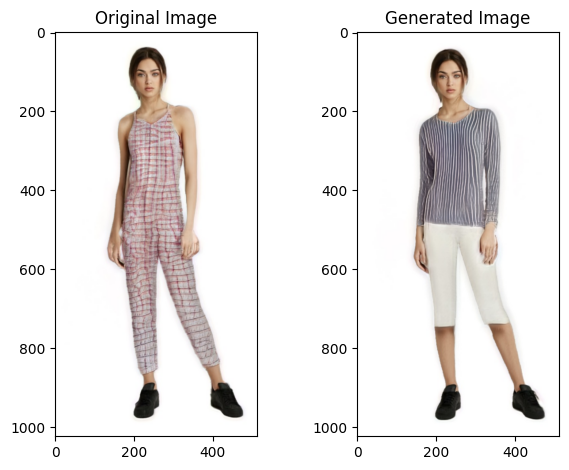

In [ ]:
import matplotlib.pyplot as plt

original_image = Image.open("/content/drive/MyDrive/Coding/Project/TinyCLIP/img/camisole_long_jumpsuits.png")
generated_image = Image.open("/content/drive/MyDrive/Coding/Project/TinyCLIP/img/long_sleeve_shirt_and_pants.png")

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(generated_image)
plt.title('Generated Image')
plt.tight_layout()
plt.show()

In [ ]:
loss = new_clip_loss(image_1, text_1, image_2, text_2)
print(loss)

tensor(0.2358, device='cuda:0', dtype=torch.float16, grad_fn=<MeanBackward0>)
